# Singular Value Decomposition (SVD) Benchmarks

## 1. Introduction
### 1.1 SVD and Use Cases
Singular Value Decomposition (SVD) is a fundamental matrix factorization technique used widely in data science, machine learning, and signal processing. It decomposes a matrix $A \in \mathbb{R}^{m \times n}$ into three matrices $U$, $\Sigma$, and $V^T$, where:

- $U$ contains the left singular vectors,
- $\Sigma$ is a diagonal matrix with singular values,
- $V^T$ contains the right singular vectors.

SVD forms the backbone of various real-world applications including:
- Dimensionality reduction (e.g., Principal Component Analysis),
- Latent Semantic Analysis in natural language processing,
- Image compression and noise reduction in signal processing,
- Collaborative filtering in recommender systems.

Despite its versatility, SVD is computationally expensive, especially for large matrices. Thus, choosing an efficient implementation is crucial for scalable systems.


## 1.2 Goal of the Experiment
The objective of this experiment is to evaluate the performance of different SVD implementations in Python:
1. A naive raw Python implementation using basic operations,
2. NumPy's optimized np.linalg.svd function,
3. PyTorch's CPU-enabled torch.linalg.svd function.

The experiment aims to answer the following:

- How does each implementation perform in terms of execution time and scalability?
- How accurate is the reconstruction of the original matrix from its SVD components?
- What are the trade-offs between simplicity, speed, and accuracy?

## 2. Background
### 2.1 SVD Algorithm Brief Explanation
Given a matrix $A \in \mathbb{R}^{m \times n}$, its SVD is:
$A = U\Sigma V^T$
where:
- $U \in \mathbb{R}^{m \times m}$ is orthogonal (left singular vectors),
- $\Sigma \in \mathbb{R}^{m \times n}$ is diagonal (singular values),
- $V^T \in \mathbb{R}^{n \times n}$ is orthogonal (right singular vectors).

Computing SVD typically involves:
- Finding eigenvalues of $A^T A$,
- Computing singular vectors via orthonormalization (e.g., Gram-Schmidt)
- Sorting components by descending singular values.


### 2.2 Differences in Implementations
- **Raw Python** manually performs the steps of SVD using basic Python operations and nested loops.
- **NumPy’s np.linalg.svd function** leverages highly optimized linear algebra libraries such as LAPACK or OpenBLAS, which are written in C and Fortran. These libraries use advanced algorithms, efficient memory management, and can take advantage of multi-threading on modern CPUs.
- **PyTorch’s torch.linalg.svd function** provides a similar high-performance SVD operation as NumPy. On CPU, PyTorch also relies on optimized linear algebra backends like MKL or OpenBLAS and supports multi-threaded execution.

## 3. Experiment Setup
### 3.1 Hardware and Software Environment
- CPU: Apple M2 Pro
- Total Number of Cores: 12
- GPU: None
- RAM: 16 GB
- OS: macOS
- Python 3.13.x
- NumPy	2.2.6
- PyTorch	2.7.x

### 3.2 Matrix Generation Method
To ensure reproducibility and control over experiment parameters, input matrices are generated using:

```bash
import numpy as np

def generate_random_matrix(n, m, seed=42):
    np.random.seed(seed)
    return np.random.rand(n, m)
```

- Square matrices (n=m) such as 100x100, 200x200, 500x500, 1000x1000, 2000x2000 will be tested.
- The same matrix will be used across all implementations for fair comparison.


## 4. Methodology

### 4.1 Implementation
- Raw Python: A custom implementation using the power iteration method to compute the dominant (top-1) singular value and corresponding singular vectors.

- NumPy: Uses np.linalg.svd, internally calling optimized LAPACK routines.

- PyTorch: Uses torch.linalg.svd, suitable for large-scale data and deep learning pipelines.

Each implementation returns the top k singular values and vectors for fair benchmarking.

### 4.2 Metrics Definition
- Execution Time: Time required to compute the SVD of a single matrix (using time.perf_counter).
- Reconstruction Error: A measure of the accuracy of the decomposition, quantified by the Frobenius norm of the difference between the original matrix and its reconstruction from the computed SVD components.
- Scalability: An analysis of how execution time grows as the dimensions of the input matrix increase. 
- Multi-processes Performance: An evaluation of how execution time is affected by varying the number of processes (1, 4, 8, 12) for a fixed matrix size.

All results will be reported with clear graphs and tables to highlight trade-offs between performance and accuracy.

## 5. Results Analysis

### 5.1 Single Process

#### 5.1.1 Performance Analysis

**Expectation**
- The optimized library implementations NumPy and PyTorch would significantly outperform the raw Python implementation in terms of execution time, especially as the size of the input matrix increases. Both libraries use highly optimized low-level linear algebra routines (typically based on LAPACK/BLAS), while the raw Python implementation is not optimized and runs purely in Python, making it considerably slower. 
- It was anticipated that NumPy and PyTorch would demonstrate similar performance on CPU for single-processed workloads, as both often rely on similar backend libraries.

**Result**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
# List all CSV files in the data folder
csv_files = glob.glob("data/benchmark_*.csv")

# Container for all DataFrames
dfs = []

# Process each file
for file in csv_files:
    # Extract parameters from filename using regex
    match = re.search(r"benchmark_s(\d+)_k(\d+)_i(\d+)_t(\d+)\.csv", file)
    if match:
        size, k, iterations, processes = match.groups()
        df = pd.read_csv(file)
        # Add metadata columns
        df['size'] = int(size)
        df['k'] = int(k)
        df['iterations'] = int(iterations)
        df['processes'] = int(processes)
        dfs.append(df)

# Concatenate all dataframes
merged_df = pd.concat(dfs, ignore_index=True)
print(merged_df.head())

   no implementation  size  processes      time  frobenius_error  \
0   1     raw_python   500          1  0.098452       275.258017   
1   2     raw_python   500          1  0.098088       275.258017   
2   3     raw_python   500          1  0.097933       275.258017   
3   4     raw_python   500          1  0.097989       275.258017   
4   5     raw_python   500          1  0.099348       275.258017   

   relative_error  k  iterations  
0        0.952962  1         100  
1        0.952962  1         100  
2        0.952962  1         100  
3        0.952962  1         100  
4        0.952962  1         100  


In [3]:
# Filter only data where processes == 1
single_process_df = merged_df[merged_df["processes"] == 1]

# Group by implementation and matrix size, then compute average time and error
summary = single_process_df.groupby(["implementation", "size"]).agg({
    "time": "mean",
    "frobenius_error": "mean",
    "relative_error": "mean"
}).reset_index()

# Sort the results for easier interpretation
summary = summary.sort_values(by=["size", "implementation"])

implementation_order = ["raw_python", "numpy", "torch"]

summary["implementation"] = pd.Categorical(summary["implementation"], categories=implementation_order, ordered=True)

summary = summary.sort_values(by=["size", "implementation"])

# Display the summary
print(summary)

   implementation  size      time  frobenius_error  relative_error
5      raw_python   100  0.003688        51.225233        0.895912
0           numpy   100  0.000894        28.525055        0.498894
10          torch   100  0.000884        28.525055        0.498894
6      raw_python   200  0.014467       106.769731        0.925931
1           numpy   200  0.003613        57.364574        0.497478
11          torch   200  0.003459        57.364574        0.497478
7      raw_python   500  0.097976       275.258017        0.952962
2           numpy   500  0.024499       144.055514        0.498730
12          torch   500  0.023895       144.055514        0.498730
8      raw_python  1000  0.410488       558.333066        0.966647
3           numpy  1000  0.117945       288.295932        0.499129
13          torch  1000  0.116556       288.295932        0.499129
9      raw_python  2000  1.696844      1127.424888        0.976379
4           numpy  2000  1.020877       577.027958        0.49

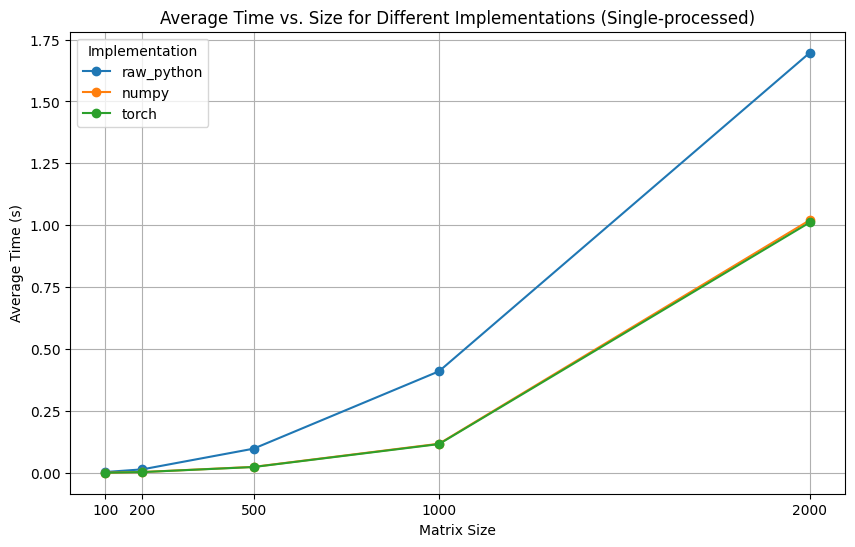

In [4]:
# Define the exact sizes to plot
exact_sizes = [100, 200, 500, 1000, 2000]

# Filter the summary DataFrame to include only the exact sizes
filtered_summary = summary[summary["size"].isin(exact_sizes)]

# Create the plot
plt.figure(figsize=(10, 6))

# Iterate through each implementation and plot the data
for implementation_name in filtered_summary["implementation"].unique():
    subset = filtered_summary[filtered_summary["implementation"] == implementation_name]
    plt.plot(subset["size"], subset["time"], marker='o', label=implementation_name)

# Add labels and title
plt.xlabel("Matrix Size")
plt.ylabel("Average Time (s)")
plt.title("Average Time vs. Size for Different Implementations (Single-processed)")
plt.legend(title="Implementation")
plt.grid(True)

# Set x-axis ticks to show only the exact sizes
plt.xticks(exact_sizes)

plt.show()

**Conclusion**
- Raw Python implementation is dramatically slower than both NumPy and PyTorch across all tested matrix sizes. As the matrix size increases, the execution time of raw Python grows much faster than that of the optimized libraries, highlighting its inefficiency for large-scale problems.
- NumPy and PyTorch perform almost identically in terms of execution time (PyTorch very slightly better), both being several times faster than raw Python. This suggests that for single-processed SVD on CPU, either library is an excellent choice for practical workloads.
- Overall, these results demonstrate the necessity of using optimized numerical libraries like NumPy or PyTorch for computationally intensive tasks such as SVD, particularly with larger datasets.


#### 5.2.2 Accuracy Analysis

**Definition**
- Frobenius Error is a measure of how far the approximated matrix (from SVD) is from the original matrix. A lower Frobenius error means the approximation is more accurate.
- Relative Error is the Frobenius error scaled by the total "size" (norm) of the original matrix. It tells what percentage of the original matrix’s information is lost. For example, relative error of 0.1 means 90% of the matrix is preserved.

**Expectation**
- NumPy and PyTorch implementations would achieve significantly lower Frobenius and relative reconstruction errors compared to the raw Python implementation. Since NumPy and PyTorch both use robust, well-tested linear algebra libraries for SVD computation, they should provide more accurate decompositions. The raw Python implementation, being a simple and less optimized algorithm (e.g., based on power iteration), was expected to show higher reconstruction errors, especially as the matrix size increases. 
- It was anticipated that the accuracy of NumPy and PyTorch would be nearly identical due to their use of similar backend libraries.

**Result**

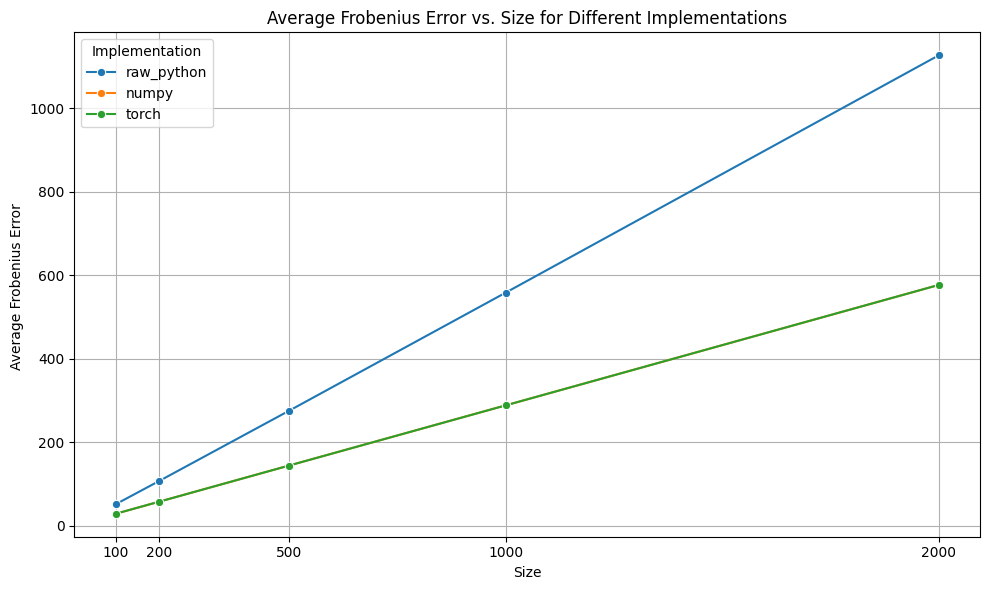

In [5]:
# Plotting the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary, x='size', y='frobenius_error', hue='implementation', marker='o')
plt.title('Average Frobenius Error vs. Size for Different Implementations')
plt.xlabel('Size')
plt.ylabel('Average Frobenius Error ')
plt.xticks(summary['size'].unique())
plt.grid(True)
plt.legend(title='Implementation')
plt.tight_layout()
plt.show()

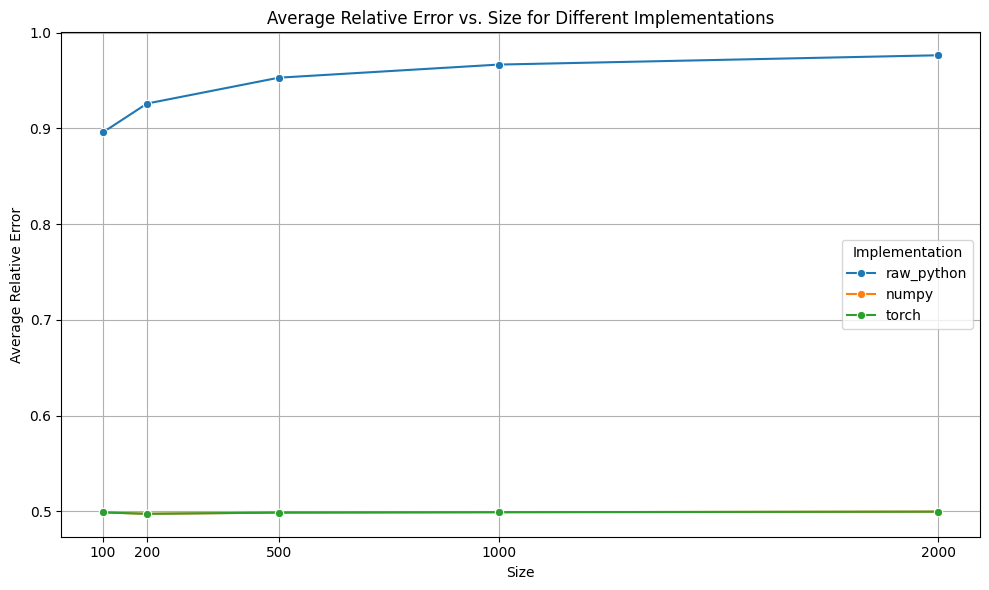

In [6]:
# Plotting the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary, x='size', y='relative_error', hue='implementation', marker='o')
plt.title('Average Relative Error vs. Size for Different Implementations')
plt.xlabel('Size')
plt.ylabel('Average Relative Error')
plt.xticks(summary['size'].unique())
plt.grid(True)
plt.legend(title='Implementation')
plt.tight_layout()
plt.show()

**Conclusion**
- NumPy and PyTorch both consistently achieve much lower Frobenius and relative errors than the raw Python implementation across all tested matrix sizes.
- For both error metrics, NumPy and PyTorch give the same result which indicates a high degree of consistency and accuracy between these two libraries. In addition, the average relative error for both libraries remain the same despite the matrix size differences.
- The raw Python implementation, by contrast, has much higher reconstruction errors, and these errors increase rapidly with the matrix size. The relative error for raw Python approaches 1.0 for large matrices, indicating that its reconstructions are far less accurate than those of NumPy or PyTorch.
- These results clearly demonstrate that for applications requiring accurate SVD decompositions, it is critical to use optimized libraries like NumPy or PyTorch, as naive implementations may not only be slower but also substantially less accurate.

### 5.2 Multi-Processing

#### 5.2.1 Performance Analysis

**Expectation**
- Increasing the number of processes would lead to decreased execution times for SVD computations, especially for the optimized NumPy and PyTorch implementations, which are designed to leverage multi-processed linear algebra backends (such as OpenBLAS or MKL). The speedup was anticipated to be more noticeable for larger matrix sizes, as there is more work to parallelize.
- For the raw Python implementation, minimal or no performance improvement was expected with additional processes, since it is not parallelized and does not utilize multi-processed libraries.

**Result**

--- Performance Summary for Multiple processes (1, 4, 8, 12) ---
   implementation  size  processes       time  frobenius_error  relative_error
20     raw_python   100          1   0.003688        51.225233        0.895912
0           numpy   100          1   0.000894        28.525055        0.498894
40          torch   100          1   0.000884        28.525055        0.498894
21     raw_python   100          4   0.003868        51.225233        0.895912
1           numpy   100          4   0.001081        28.525055        0.498894
41          torch   100          4   0.001199        28.525055        0.498894
22     raw_python   100          8   0.004087        51.225233        0.895912
2           numpy   100          8   0.001159        28.525055        0.498894
42          torch   100          8   0.001200        28.525055        0.498894
23     raw_python   100         12   0.005347        51.225233        0.895912
3           numpy   100         12   0.001528        28.525055    

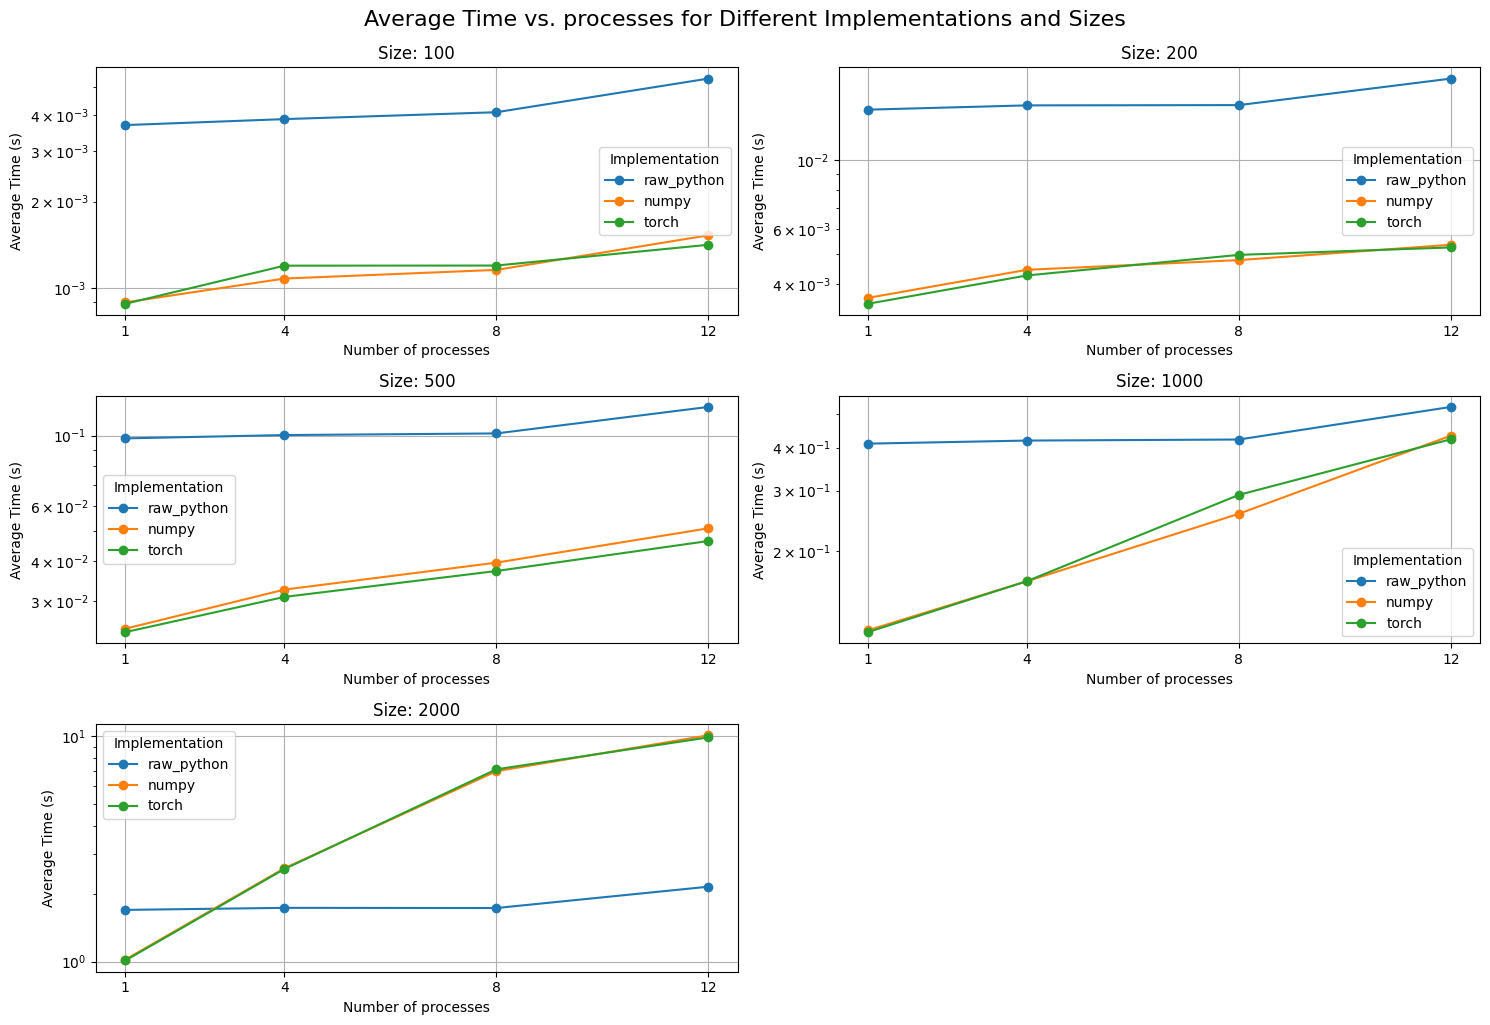

In [7]:
sizes = [100, 200, 500, 1000, 2000]

# Define the process counts to analyze
multi_process_counts = [1, 4, 8, 12]

# Filter data for multiple processes
multi_process_df = merged_df[merged_df["processes"].isin(multi_process_counts)]

# Group by implementation, matrix size, and processes, then compute average time and error
multi_process_summary = multi_process_df.groupby(["implementation", "size", "processes"]).agg({
    "time": "mean",
    "frobenius_error": "mean",
    "relative_error": "mean"
}).reset_index()

# Define the desired order for 'implementation'
implementation_order = ["raw_python", "numpy", "torch"]

# Convert 'implementation' to a categorical type with the desired order
multi_process_summary["implementation"] = pd.Categorical(multi_process_summary["implementation"], categories=implementation_order, ordered=True)

# Sort by the new categorical 'implementation' column along with size and processes
multi_process_summary = multi_process_summary.sort_values(by=["size", "processes", "implementation"])

print("--- Performance Summary for Multiple processes (1, 4, 8, 12) ---")
print(multi_process_summary)


# Plotting Average Time vs. processes for each Implementation and Size
plt.figure(figsize=(15, 10))

# Get unique sizes for subplots
unique_sizes = multi_process_summary["size"].unique()
num_rows = (len(unique_sizes) + 1) // 2 # 2 plots per row

for i, s in enumerate(unique_sizes):
    plt.subplot(num_rows, 2, i + 1) # Create subplots
    size_subset = multi_process_summary[multi_process_summary["size"] == s]

    for impl in implementation_order:
        impl_subset = size_subset[size_subset["implementation"] == impl]
        plt.plot(impl_subset["processes"], impl_subset["time"], marker='o', label=impl)

    plt.xlabel("Number of processes")
    plt.ylabel("Average Time (s)")
    plt.title(f"Size: {s}")
    plt.xticks(multi_process_counts) 
    plt.legend(title="Implementation")
    plt.grid(True)
    plt.yscale('log')

plt.tight_layout()
plt.suptitle("Average Time vs. processes for Different Implementations and Sizes", y=1.02, fontsize=16)
plt.show()

**Conclusion**
- The data shows that for all three implementations (raw_python, numpy, and torch) and across all tested matrix sizes (from 100x100 to 2000x2000), increasing the number of processes consistently led to an increase in average execution time. The performance did not improve with added processes; it degraded.
- This unexpected behavior may be caused by several factors:
  - **Raw Python**
    - No True Parallelism: Because of the Global Interpreter Lock (GIL), even on a multi-core processor, multiple processes in a CPU-bound Python program cannot run in parallel. They are forced to run sequentially.
    - Added Overhead: When increasing the number of processes, it is not gaining any parallel computation. Instead, it adds the overhead of context switching. The operating system has to spend time switching between the processes, each of which is just waiting for its turn to acquire the GIL.
  - **Numpy and Pytorch**
    - These libraries bypass the GIL by calling highly optimized and pre-compiled C, C++, or Fortran code (like OpenBLAS, MKL, or LAPACK). These underlying libraries can and do use multiple processes for computation.
    - However, the degrade in performance can be due to the cost of parallelization overhead which includes:
      - Process Creation & Management: The process of creating, synchronizing, and tearing down processes takes time.
      - Data Partitioning & Aggregation: The matrix must be broken down into smaller pieces for each process to work on, and the results must be combined afterward. This is not an instantaneous process.
      - Memory Bandwidth & Cache Issues: SVD is a memory-intensive operation. When multiple processes run simultaneously, they compete for access to the system's memory bus and CPU caches. This contention can lead to processes waiting for data, negating the benefits of parallel processing.
- For the matrix sizes in this experiment, the computation itself is likely so fast on modern CPUs that the overhead of managing the processes is greater than the time saved by parallel execution. It is simply faster for a single core to perform the entire calculation than it is to coordinate the work among multiple cores. This is common for tasks that are not sufficiently large or complex to amortize the cost of parallelization.
- The experiment demonstrates a critical concept in performance engineering: more processes does not automatically mean better performance. It highlights that blindly adding processes without considering the problem size and the overhead involved can be counterproductive.

## 6. Limitations

- **Hardware Constraints**: All experiments were conducted on a single hardware configuration (Apple M2 Pro, CPU only). Results may differ on systems with different CPUs, more cores, or on dedicated GPUs, especially for PyTorch.
- **Fixed Data Size Range**: Matrix sizes tested were between 100 and 2000. Larger or smaller matrices, or non-square matrices, may result in different trends.

## 7. Conclusion

This study systematically benchmarked three different SVD implementations: raw Python, NumPy, and PyTorch, under varying matrix sizes and process counts to evaluate their performance and accuracy. The results confirm that the choice of implementation is critical. Both NumPy and PyTorch consistently delivered dramatically faster and more accurate SVD computations compared to the naive raw_python implementation. This highlights the indispensable role of optimized, low-level backend routines (like BLAS and LAPACK) in numerical computing.

For any real-world application requiring SVD, using optimized libraries like NumPy or PyTorch is non-negotiable for achieving acceptable performance and accuracy. However, this study serves as a critical reminder that "more processes" does not automatically equate to "more speed." Performance benefits from multi-processing are only realized when the computational task is large enough to amortize the associated overhead. Therefore, developers should be cautious about parallelization strategies and recognize that for moderately-sized problems, a single-processed approach may yield the best performance.